<a href="https://colab.research.google.com/github/SourLemon23/covid19-diagnosis/blob/master/COVID_19_CT_Diagnosis_V16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [286]:
import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

import tensorflow.keras.backend as K
from tensorflow import GradientTape

from tensorflow.image import resize
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score

import os
from pathlib import Path
import csv
import nibabel as nib
import datetime

import numpy as np
import matplotlib.pyplot as plt
import cv2

! pip install -U efficientnet
from efficientnet.tfkeras import EfficientNetB7

Using TensorFlow Version: 2.4.0
Requirement already up-to-date: efficientnet in /usr/local/lib/python3.6/dist-packages (1.1.1)


In [2]:
# Check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

GPU device not found


In [3]:
# Authorize access to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
training_dir   = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V9/Training'
validation_dir = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V9/Validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V9/Testing'

In [5]:
# Saved weights and model
checkpoint_filepath = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/weights.h5'
model_filepath = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/model'

In [6]:
# Tensorboard logs
logs = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/logs'

In [69]:
CLASSES = ['COVID-19 Positive', 'COVID-19 Negative']

CHANNELS = 3
COLOR_MODE = 'rgb'

IMG_WIDTH, IMG_HEIGHT = 224, 224
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

LEARNING_RATE = 0.001
MIN_DELTA = 1e-5
PATIENCE = 7
BATCH_SIZE = 32
EPOCHS = 30

METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall')]

COVID_THRESHOLD = 0.4
THRESHOLD_VALUE = 0.5
NORMAL_THRESHOLD = 0.6

PERCENTAGE_FACTOR = 100;

font_settings = {'family': 'DejaVu Sans',
                  'color' : 'red',
                  'weight': 'heavy',
                  'size'  :  11}

**Data Preprocessing**

In [8]:
def load_data(dir):
    img_paths = []

    for root, dirs, files in os.walk(dir):
        for filename in files:
            abs_path = os.path.abspath(os.path.join(root, filename))
            img_paths.append(abs_path)

    return img_paths

In [9]:
def extract_slices(orig_slices_dir, lesion_slices_file):
    orig_paths = []
    for root, dirs, files in os.walk(orig_slices_dir):
        for filename in files:
            abs_path = os.path.abspath(os.path.join(root, filename))
            orig_paths.append(abs_path)

    with open(lesion_slices_file, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)

        lesion_paths = []
        for line in csv_reader:
            abs_path = Path(orig_slices_dir).parent + line[0].replace('/', '\\')

            lesion_paths.append(abs_path)

    csv_file.close()

    for img_path in orig_paths:
        if img_path not in lesion_paths:
            os.remove(img_path)

In [108]:
def lungs_region_auto_crop(img_path=None, img_array=None, plot=False):
    if img_path is not None:
        img = cv2.imread(img_path)
        img2 = img.copy()
    else:
        img = img_array
        img2 = img_array.copy()

    grayscale_img = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    smoothed_img = cv2.GaussianBlur(grayscale_img, (5, 5), 0)

    binary_img = cv2.threshold(smoothed_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    kernel = np.ones((8, 8), dtype=np.uint8)
    eroded_img = cv2.erode(binary_img, kernel, iterations=1)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(contour) for contour in contours]

    max_index = np.argmax(areas)
    contour = contours[max_index]
    cv2.drawContours(img2, contours, -1, (0, 255, 0), 3)

    x, y, w, h = cv2.boundingRect(contour)
    xmin = x
    xmax = x + w
    ymin = y
    ymax = y + h
    cv2.rectangle(img2, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    cropped_img = img[ymin:ymax, xmin:xmax]

    if plot:
        fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(24, 4), constrained_layout=True)
        
        for i, img_filter in enumerate(['Grayscale', 'Smoothed', 'Binary', 'Eroded', 'Dilated', 'Contoured', 'Cropped']):
            axs[i].set_title(img_filter)

        axs[0].imshow(grayscale_img)
        axs[1].imshow(smoothed_img)
        axs[2].imshow(binary_img)
        axs[3].imshow(eroded_img)
        axs[4].imshow(dilated_img)
        axs[5].imshow(img2)
        axs[6].imshow(cropped_img)

        plt.show()

    return cropped_img

In [287]:
# def exterior_exclusion(image):
#     grayscale_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     smoothed_img = cv2.GaussianBlur(grayscale_img, (5, 5), 0)
#     binary_img = cv2.threshold(smoothed_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#     kernel = np.ones((8, 8), dtype=np.uint8)
#     eroded_img = cv2.erode(binary_img, kernel, iterations=1)
#     dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

#     contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     areas = [cv2.contourArea(contour) for contour in contours]

#     max_index = np.argmax(areas)
#     contour = contours[max_index]

#     body_mask = np.zeros((224, 224), dtype=np.uint8)
#     cv2.drawContours(body_mask, [contour], 0, 1, -1)
#     body_mask = body_mask.astype(bool)
#     bg_mask = (~body_mask) & (image > 0)[:, :, 0]
#     dark_bg_mask = bg_mask & (~binary_img)
#     bg_mean = np.mean(image[dark_bg_mask])
#     image[bg_mask] = bg_mean

#     return image

In [11]:
def process_data(file_paths, crop=False):
    processed_png_imgs = []

    for img_path in file_paths:
        if crop:
            cropped_img = lungs_region_auto_crop(img_path=img_path)
            processed_png_imgs.append(cropped_img)
        else:
            img = cv2.imread(img_path)
            processed_png_imgs.append(img)

    return processed_png_imgs

In [254]:
def write_imgs(img_paths, processed_imgs, new_dir):
    for i, img_path in enumerate(img_paths):
        path_after_dir = r'/'.join(Path(img_path).parts[7:])
        final_img_path = Path(os.path.join(new_dir, path_after_dir))
        final_img_dir = final_img_path.parent

        if os.path.isdir(str(final_img_dir)) == False:
            os.makedirs(final_img_dir)
            print('New directory made:', final_img_dir)
          
        cv2.imwrite(str(final_img_path), processed_imgs[i])

In [13]:
# # Crop images within a directory
# dir = r''
# new_dir = r''

# img_paths = load_data(dir)
# print('# img paths:', len(img_paths))

# processed_imgs = process_data(img_paths, crop=True)
# print('# imgs processed:', len(processed_imgs))

# write_imgs(img_paths, processed_imgs, new_dir)

In [14]:
def visualize_augmentations(data_generator):
    batch = data_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]

    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(24, 14), constrained_layout=True)
    batch_length = len(image_batch)

    for i, image in enumerate(image_batch):
        if int(batch_labels[i]) == 0:
            title = 'COVID-19'
            font_settings.update({'color': 'red'})
        else:
            title = 'Normal'
            font_settings.update({'color': 'blue'})

        if i < (1 / 4) * batch_length:
            axs[0, i].imshow(image_batch[i])
            axs[0, i].set_title(title, fontdict=font_settings)
        elif i < (2 / 4) * batch_length:
            axs[1, i - 8].imshow(image_batch[i])
            axs[1, i - 8].set_title(title, fontdict=font_settings)
        elif i < (3 / 4) * batch_length:
            axs[2, i - 16].imshow(image_batch[i])
            axs[2, i - 16].set_title(title, fontdict=font_settings)
        else:
            axs[3, i - 24].imshow(image_batch[i])
            axs[3, i - 24].set_title(title, fontdict=font_settings)

    plt.show()

In [317]:
image
training_data_gen = image.ImageDataGenerator(rescale=1./255,              # Simplify pixel values to be 0-1
                                       horizontal_flip=True,        # Randomly flip images horizontally
                                       zoom_range=0.1,              # Randomly zoom
                                       shear_range=0.1,             # Shear angle in counter-clockwise direction
                                       rotation_range=10,           # Randomly rotate
                                       width_shift_range=0.05,      # Randomly shift the image left/right
                                       height_shift_range=0.05,     # Randomly shift the image up/down
                                       fill_mode='constant',        # Filling mode for points outside boundaries
                                       cval=60,                     # Value used for points outside the boundaries
                                       brightness_range=(0.8, 1.2)) # Randomly adjust the brightness

validation_data_gen = image.ImageDataGenerator(rescale=1./255)

testing_data_gen = image.ImageDataGenerator(rescale=1./255)

In [307]:
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           color_mode=COLOR_MODE,
                                                           target_size=TARGET_SIZE,
                                                           class_mode='binary',
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               color_mode=COLOR_MODE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode='binary',
                                                               batch_size=BATCH_SIZE,
                                                               shuffle=True)

testing_generator = testing_data_gen.flow_from_directory(testing_dir,
                                                         color_mode=COLOR_MODE,
                                                         target_size=TARGET_SIZE,
                                                         class_mode='binary',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

Found 14159 images belonging to 2 classes.
Found 1755 images belonging to 2 classes.
Found 1784 images belonging to 2 classes.


In [ ]:
print('Training Batch:')
visualize_augmentations(training_generator)
print('\n\n\nValidation Batch:')
visualize_augmentations(validation_generator)

**Building the Model**

In [18]:
def create_model(print_summary=False):
    # Instantiate a base model with pre-trained weights
    base_model = EfficientNetB7(weights='imagenet',
                                include_top=False,
                                input_shape=INPUT_SHAPE)
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output

    # Add new layers to the end of the base model
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)

    # A final dense layer with a single neuron (binary classification)
    predictions = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.inputs, outputs=predictions)

    if print_summary:
        model.summary()

    return model

In [19]:
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=LEARNING_RATE),
                  metrics=METRICS)

In [20]:
def fit_model(model):
    checkpoint_cb = ModelCheckpoint(checkpoint_filepath,
                                    monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True)

    early_stopping_cb = EarlyStopping(monitor='val_accuracy',
                                      min_delta=MIN_DELTA,
                                      patience=PATIENCE,
                                      mode='max',
                                      restore_best_weights=True)
    
    log_dir = logs + r'/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_cb = TensorBoard(log_dir=log_dir,
                                 histogram_freq=1)
    
    callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb]

    history = model.fit(training_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=(training_generator.n/BATCH_SIZE),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/BATCH_SIZE),
                        callbacks=callbacks)
    
    # Update weights that may have been further optimized during training
    model.load_weights(checkpoint_filepath)
    
    return history

In [21]:
def evaluate_model(history):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 4), constrained_layout=True)

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
        if ('loss' in metric) is False:
            print('Best Training ' + metric.capitalize() + ':', str(max(history.history[metric]) * 100)[:5] + '%')
            print('Best Validation ' + metric.capitalize() + ':', str(max(history.history['val_' + metric]) * 100)[:5] + '%')
        else:
            print('Best Training ' + metric.capitalize() + ':', str(min(history.history[metric]))[:5])
            print('Best Validation ' + metric.capitalize() + ':', str(min(history.history['val_' + metric]))[:5])
        
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])

In [22]:
model = load_model(model_filepath)

In [23]:
# model = create_model(print_summary=True)
# compile_model(model)

In [24]:
# history = fit_model(model)

In [25]:
# evaluate_model(history)

In [26]:
# model.save(model_filepath)

**Testing & Data Analysis**

In [94]:
def plot_confusion_matrix(data_generator, predictions):
    cm = confusion_matrix(y_true=data_generator.labels, y_pred=predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=CLASSES[::-1])
    
    disp.plot(include_values=True,
              cmap='Blues',
              xticks_rotation=45,
              values_format='.5g')
    
    plt.title('Confusion Matrix', fontdict = {'family': 'DejaVu Sans',
                                              'color' : 'black',
                                              'weight': 'heavy',
                                              'size'  :  12})

In [28]:
def plot_roc_curve(data_generator, predictions):
    ns_predictions = [0 for i in range(data_generator.n)]

    ns_auc = roc_auc_score(y_true=data_generator.labels, y_score=ns_predictions)
    auc = roc_auc_score(y_true=data_generator.labels, y_score=predictions)

    fpr, tpr, thresholds = roc_curve(y_true=testing_generator.labels, y_score=predictions)
    ns_fpr, ns_tpr, ns_thresholds = roc_curve(y_true=testing_generator.labels, y_score=ns_predictions)

    plt.plot(fpr, tpr, marker='.', label='Logistic Regression (AUC = %0.3f)' % auc)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (AUC = %0.3f)' % ns_auc)

    plt.title('ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [29]:
def print_classification_report(data_generator, predictions):
    cr = classification_report(y_true=data_generator.labels, y_pred=predictions)
    print(cr)

In [99]:
def grad_CAM(model, orig_img, intensity_factor, plot=True):
    with GradientTape() as tape:
        last_conv_layer = model.get_layer('top_conv')
        iterate = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(orig_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS))
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    np.seterr(divide='ignore', invalid='ignore')
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape(7, 7)

    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    colormap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_HSV)

    dimmed_heatmap = colormap * intensity_factor
    
    superimposed_img = ((dimmed_heatmap + orig_img) * 180).astype(np.uint8)

    if plot:
        plt.imshow(superimposed_img)
        plt.show()

    return superimposed_img, heatmap

In [31]:
def visualize_grad_CAMS(model, data_generator):
    batch = data_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]

    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(24, 14), constrained_layout=True)
    batch_length = len(image_batch)

    for i, image in enumerate(image_batch):
        orig_img = image_batch[i]

        if int(batch_labels[i]) == 0:
            title = 'True Label: COVID-19'
            font_settings.update({'color': 'red'})
        elif int(batch_labels[i]) == 1:
            title = 'True Label: Normal'
            font_settings.update({'color': 'blue'})
        
        superimposed_img, heatmap = grad_CAM(model, orig_img, 0.0015, plot=False)

        if i < (1 / 4) * batch_length:
            axs[0, i].imshow(superimposed_img)
            axs[0, i].set_title(title, fontdict=font_settings)
        elif i < (2 / 4) * batch_length:
            axs[1, i - 8].imshow(superimposed_img)
            axs[1, i - 8].set_title(title, fontdict=font_settings)
        elif i < (3 / 4) * batch_length:
            axs[2, i - 16].imshow(superimposed_img)
            axs[2, i - 16].set_title(title, fontdict=font_settings)
        else:
            axs[3, i - 24].imshow(superimposed_img)
            axs[3, i - 24].set_title(title, fontdict=font_settings)

    plt.show()

In [32]:
def select_testing_image(img_dir, image_index, show_true_label=False):
    data_gen = ImageDataGenerator(rescale=1./255)
    img_generator = data_gen.flow_from_directory(img_dir,
                                                color_mode=COLOR_MODE,
                                                target_size=TARGET_SIZE,
                                                class_mode='binary',
                                                shuffle=False)
    img_generator.batch_size = img_generator.n

    batch = img_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]

    testing_image = (image_batch[image_index - 1] * 255).astype(np.uint8)
    true_label = CLASSES[int(batch_labels[image_index - 1])]

    if show_true_label:
        if true_label == 'COVID-19 Positive':
            title = 'COVID-19'
            font_settings.update({'color': 'red'})
        else:
            title = 'Normal'
            font_settings.update({'color': 'blue'})
        
        plt.title(f'True Label: {title}', fontdict=font_settings)
        plt.imshow(testing_image)
        plt.show()

    return testing_image

In [33]:
def run_diagnosis(model, img_path=None, img_array=None):
    disclaimer = '*** DISCLAIMER ***\n' \
             'Do not rely on this prediction for self-diagnosis. ' \
             'Please check with your local authority services for ' \
             'seeking medical assistance.'

    plt.text(0, 0.5,
            disclaimer,
            size=15,
            ha="center", va="center",
            bbox=dict(boxstyle="round",
                      ec=(1., 0., 0.),
                      fc=(1., 0.9, 0.9)))
    plt.axis('off')
    
    if img_path is not None:
        cropped_img = lungs_region_auto_crop(img_path=img_path, plot=True)
    else:
        cropped_img = lungs_region_auto_crop(img_array=img_array, plot=True)

    resized_img = np.asarray(resize(cropped_img, TARGET_SIZE)).astype(np.uint8)
    np.seterr(divide='ignore', invalid='ignore')
    resized_img = resized_img / 255

    testing_img = resized_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS)
    prediction = model.predict(testing_img)[0][0]
    # print('Prediction:', prediction)

    # Safe prediction for COVID-19 positive
    if prediction > 0 and prediction < COVID_THRESHOLD:
        class_index = 0
        network_prediction = CLASSES[class_index]

        # network_percent_confidence = str(((THRESHOLD_VALUE - prediction) / THRESHOLD_VALUE) * PERCENTAGE_FACTOR)[2:6]
        network_percent_confidence = str((1 - prediction) * PERCENTAGE_FACTOR)[:5]

        font_settings.update({'color': 'red'})
        plt.title(f'{network_prediction} ({network_percent_confidence}% match)', fontdict=font_settings)

    # Safe prediction for COVID-19 negative
    elif prediction < 1 and prediction > NORMAL_THRESHOLD:
        class_index = 1
        network_prediction = CLASSES[class_index]

        # network_percent_confidence = str(((prediction - THRESHOLD_VALUE) / THRESHOLD_VALUE) * PERCENTAGE_FACTOR)[2:6]
        network_percent_confidence = str(prediction * PERCENTAGE_FACTOR)[:5]
        
        font_settings.update({'color': 'blue'})
        plt.title(f'{network_prediction} ({network_percent_confidence}% match)', fontdict=font_settings)

    else:
        network_prediction = 'Uncertain'

        font_settings.update({'color': 'yellow'})
        plt.title(network_prediction, fontdict=font_settings)

    plt.imshow(cropped_img)
    plt.show()

    superimposed_img, guided_cam = grad_CAM(model, resized_img, 0.0015, plot=False)

    gb_model = Model(inputs = [model.inputs], outputs = [model.layers[-7].output])
    # layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]

    # @tf.custom_gradient
    # def guidedRelu(x):
    #     def grad(dy):
    #         return tf.cast(dy>0, "float32") * tf.cast(x>0, "float32") * dy
    #     return tf.nn.relu(x), grad
    #     # return tf.nn.swish(x), grad
    #     # return tf.nn.silu(x), grad

    # for layer in layer_dict:
    #     # print(layer.activation)

    #     # if 'swish' in str(layer.activation):
    #     if 'custom_gradient' in str(layer.activation):
    #     # if layer.activation == tf.keras.activations.swish:
    #         # print('found a swish!')
    #         layer.activation = guidedRelu

    # get layers that have an activation
    # layer_dict = [layer for layer in model.layers[1:] if hasattr(layer, 'activation')]

    with GradientTape() as tape:
        inputs = tf.cast(img_array.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS), tf.float32)
        tape.watch(inputs)
        outputs = gb_model(inputs)[0]
        bp_grads = tape.gradient(outputs,inputs)[0]

    # weights = tf.reduce_mean(bp_grads, axis=(0, 1))
    # new_grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
    # for i, w in enumerate(weights):
    #     new_grad_cam += w * outputs[:, :, i]

    # plt.imshow(new_grad_cam)
    # plt.show()

    # guided_cam = np.maximum(new_grad_cam, 0)
    # guided_cam = guided_cam / np.max(guided_cam) # scale 0 to 1.0
    # import skimage
    # guided_cam = skimage.transform.resize(guided_cam, (224,224), preserve_range=True)
    # # print('guided cam shape', guided_cam.shape)
    # plt.imshow(guided_cam)
    # plt.show()

    # GUIDED Backpropagation
    guided_bp = bp_grads

    guided_bp = np.dstack((guided_bp[:, :, 0],
                           guided_bp[:, :, 1],
                           guided_bp[:, :, 2]))
                
    enhanced_guided_bp = guided_bp / guided_bp.max()
    guided_bp -= np.min(guided_bp)
    norm_guided_bp = guided_bp / guided_bp.max()

    # Guided Grad-CAM
    guided_gc = np.dstack((norm_guided_bp[:, :, 0] * guided_cam,
                           norm_guided_bp[:, :, 1] * guided_cam,
                           norm_guided_bp[:, :, 2] * guided_cam))


    enhanced_guided_gc = np.dstack((enhanced_guided_bp[:, :, 0] * guided_cam,
                                    enhanced_guided_bp[:, :, 1] * guided_cam * 3,
                                    enhanced_guided_bp[:, :, 2] * guided_cam))

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
    axs[0, 0].imshow(superimposed_img)
    axs[0, 1].imshow(np.clip(norm_guided_bp, a_min=0, a_max=1))
    axs[1, 0].imshow(np.clip(guided_gc, a_min=0, a_max=1))
    axs[1, 1].imshow(np.clip(enhanced_guided_gc, a_min=0, a_max=1))

    plt.show()

In [34]:
model.evaluate(testing_generator)

56/56 [==============================] - 869s 16s/step - loss: 0.1978 - accuracy: 0.9266 - precision: 0.9064 - recall: 0.9487


[0.19777080416679382,
 0.9265695214271545,
 0.9064199924468994,
 0.9487471580505371]

In [35]:
predictions = model.predict(testing_generator,
                            verbose=1)
predictions = np.around(predictions).astype(int)

56/56 [==============================] - 660s 12s/step


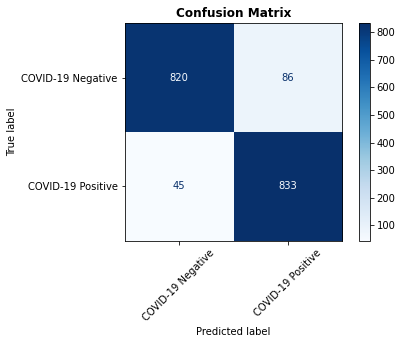

In [95]:
plot_confusion_matrix(testing_generator, predictions)

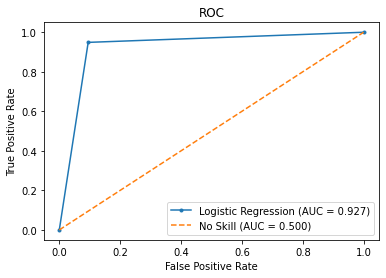

In [73]:
plot_roc_curve(testing_generator, predictions)

In [71]:
print_classification_report(testing_generator, predictions)

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       906
           1       0.91      0.95      0.93       878

    accuracy                           0.93      1784
   macro avg       0.93      0.93      0.93      1784
weighted avg       0.93      0.93      0.93      1784



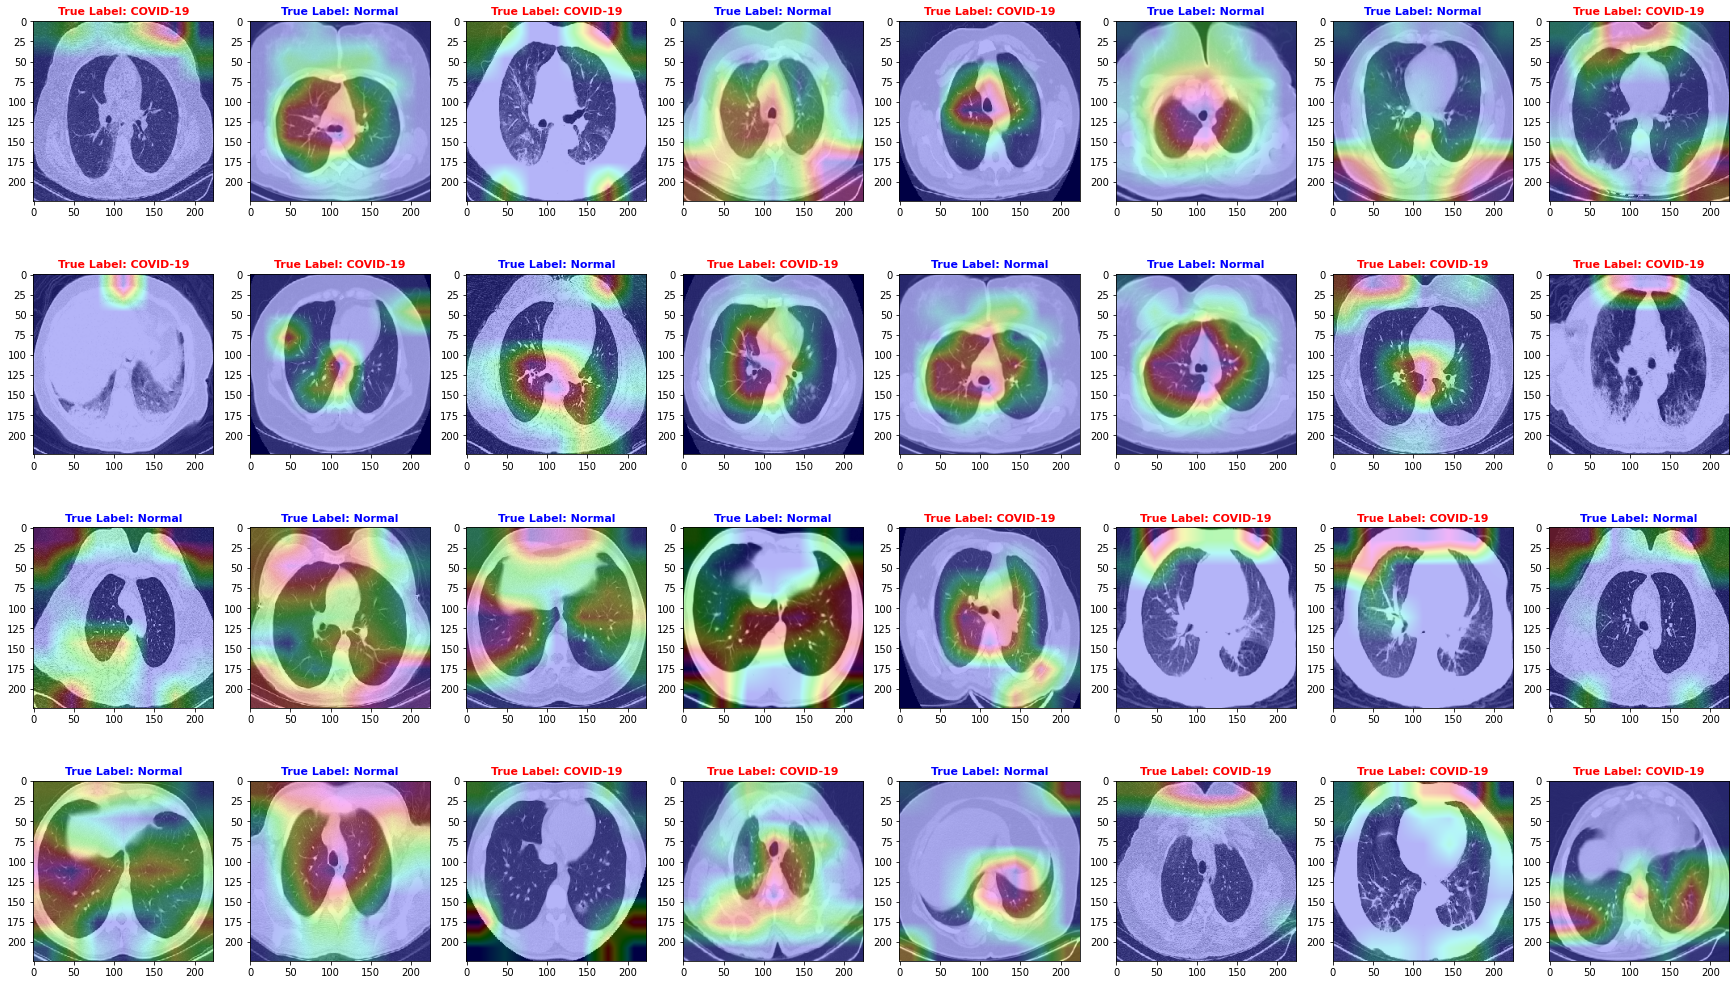

In [100]:
testing_generator.shuffle = True
visualize_grad_CAMS(model, testing_generator)

Found 100 images belonging to 2 classes.


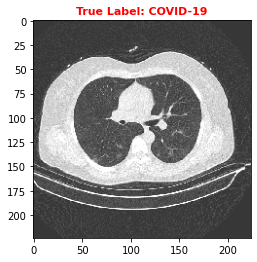

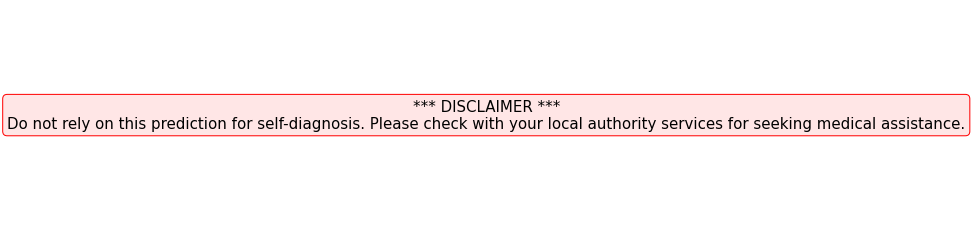

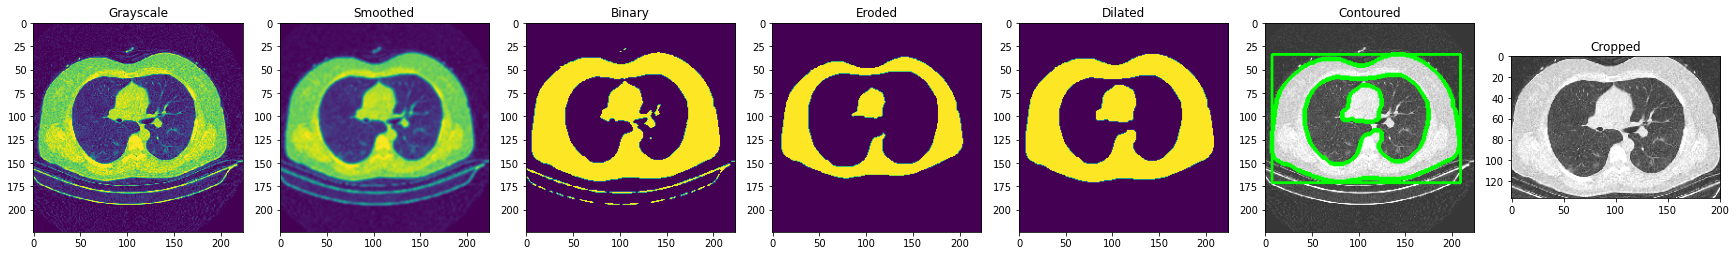

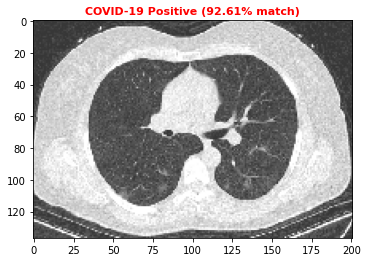

last_conv_layer: <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>


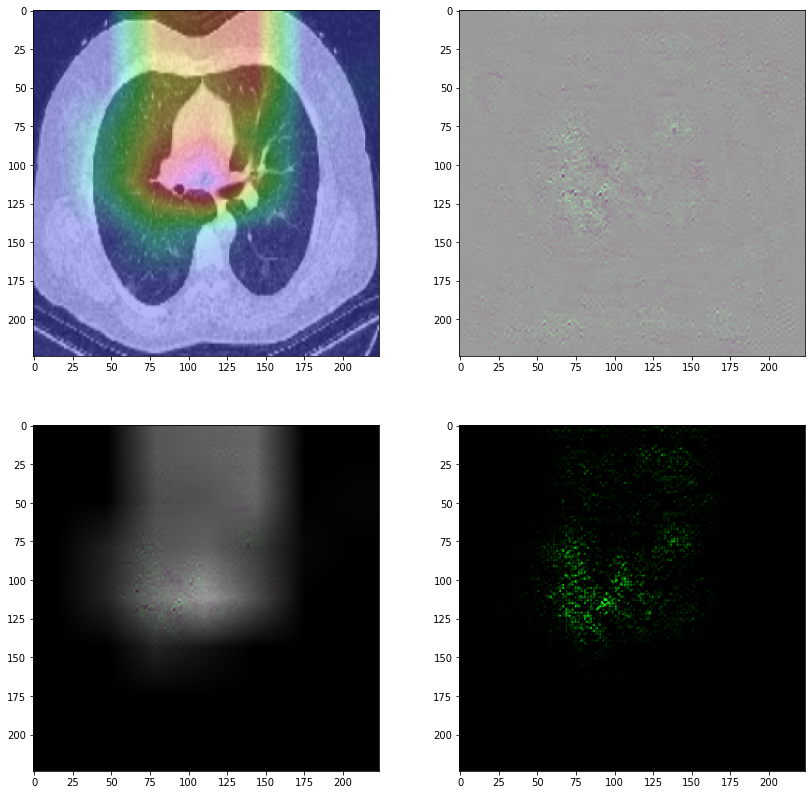

In [97]:
#@title Run a Diagnostic Test {run: "auto", vertical-output: true}
image_index = 1 #@param {type:"slider", min:1, max:100, step:1}

unprocessed_imgs = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/Unprocessed Test Images'
testing_image = select_testing_image(unprocessed_imgs, image_index, show_true_label=True)
run_diagnosis(model, img_array=testing_image)